# APS1017_Project

## 1. Overview

In this project, firstly  the dataset is visualized and explored.

The team found this dataset lookd like time-series data but with influence from different clients and materials, which leads to different time lines.

If The team considers single time line, the data are very limited, and dates are very discrete. It is hard to treat each time-line as a time-series model. What's more important, because of the discrete date, The team needs to predict whether the client will purchase or not before predict the number.

Luckily, one thing very helpful is that data is stationary, no clear trending is observed, though the variance is high. And the team captures some seasonal factors: it is a 3-month dataset, so the only useful thing is weekday and month-start or month-end.

Another finding is that all materials are sold in fixed batch, so the team uses number of batched in place of quantity, letting result more closed to reality.

In after-class method, the team chooses machine learning model to forcast. Because we can take advantage of large dataset and different features. Another reason is that we could use classify model to predict whether client will purchase or not.

Another method, as in-class method, is moving average which is useful for stationary data. To predict better, the team decided to use moving average to predict the aggregate number firstly, then distribute it into clients or materials.

After checking the result by split train-test data, two methods have their advantages and drawbacks:

Moving average works well on stationary data, and computed easy. But it cannot capture the discrete distribution of order. It assume everyday client buy things. But it shows some law of market somehow, more details are in its section.

Machine learning method is more accurate, and could predict whether client will buy. But also have some drawbacks: building it costs time and work. More importantly, due to the unbalance of records(days of buying are much fewer than not buying), although the team takes some methods to improve the performance, the model still tends to predict one record as "won't buy", the recall score is about 0.58. So please try more times or predict aggregate number in Interactive Part :)

In the end, a thrid method, FbProphet model has been exploited as a matter of interest. 

## 2. Explanation and Visualization of the Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## Re-running entire project requires rougly 30 minutes
## If run this file in Colab, please swtich to the following code to load data
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.StringIO(uploaded['APS1017 Order data for Project.csv'].decode('utf-8')))

In [2]:
df=pd.read_csv('APS1017 Order data for Project.csv')
df['Date']=pd.to_datetime(df['Date'])
client_list=df['Client'].unique()
material_list=df['Material'].unique() 

### 2.1. Visualization of Raw Data

It is necessary to generate some graphs of raw data at the beginning in order to get a short view. Let's just consider clients first.

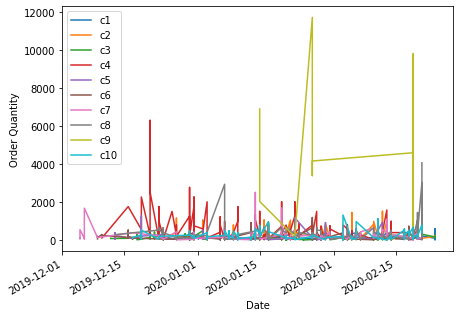

In [3]:
#materials not considered
c1 = df[df['Client'] == 'c1']
ax = c1.plot(x='Date', y='Order Quantity', label='c1', figsize=(7,5))
ax.set_ylabel('Order Quantity')
names = locals()
for i in range(9):
    names['c' + str(i+2)] = df[df['Client'] == 'c' + str(i+2)]
    ax = names.get('c' + str(i+2)).plot(x='Date', y='Order Quantity', ax=ax, label="c"+str(i+2))

As can be seen, there are no obvious rules in this graph. Let's then check for materials, with clients not considered.

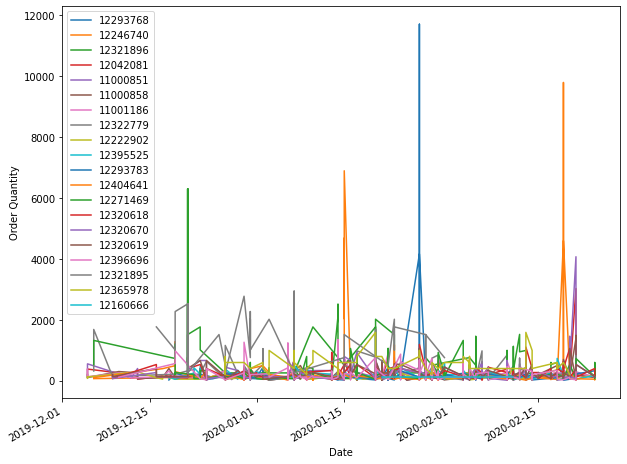

In [4]:
#clients not considered
names = locals()
m0 = df[df['Material'] == material_list[0]]
ax = m0.plot(x='Date', y='Order Quantity', label=str(material_list[0]), figsize=(10,8))
ax.set_ylabel('Order Quantity')

for i in range(19):
    names[material_list[i+1]] = df[df['Material'] == material_list[i+1]]
    ax = names.get(material_list[i+1]).plot(x='Date', y='Order Quantity', ax=ax, label=str(material_list[i+1]))

The result is similar with the previous graph. Totally a mess. Let's generate graphs for each pair of client and material.

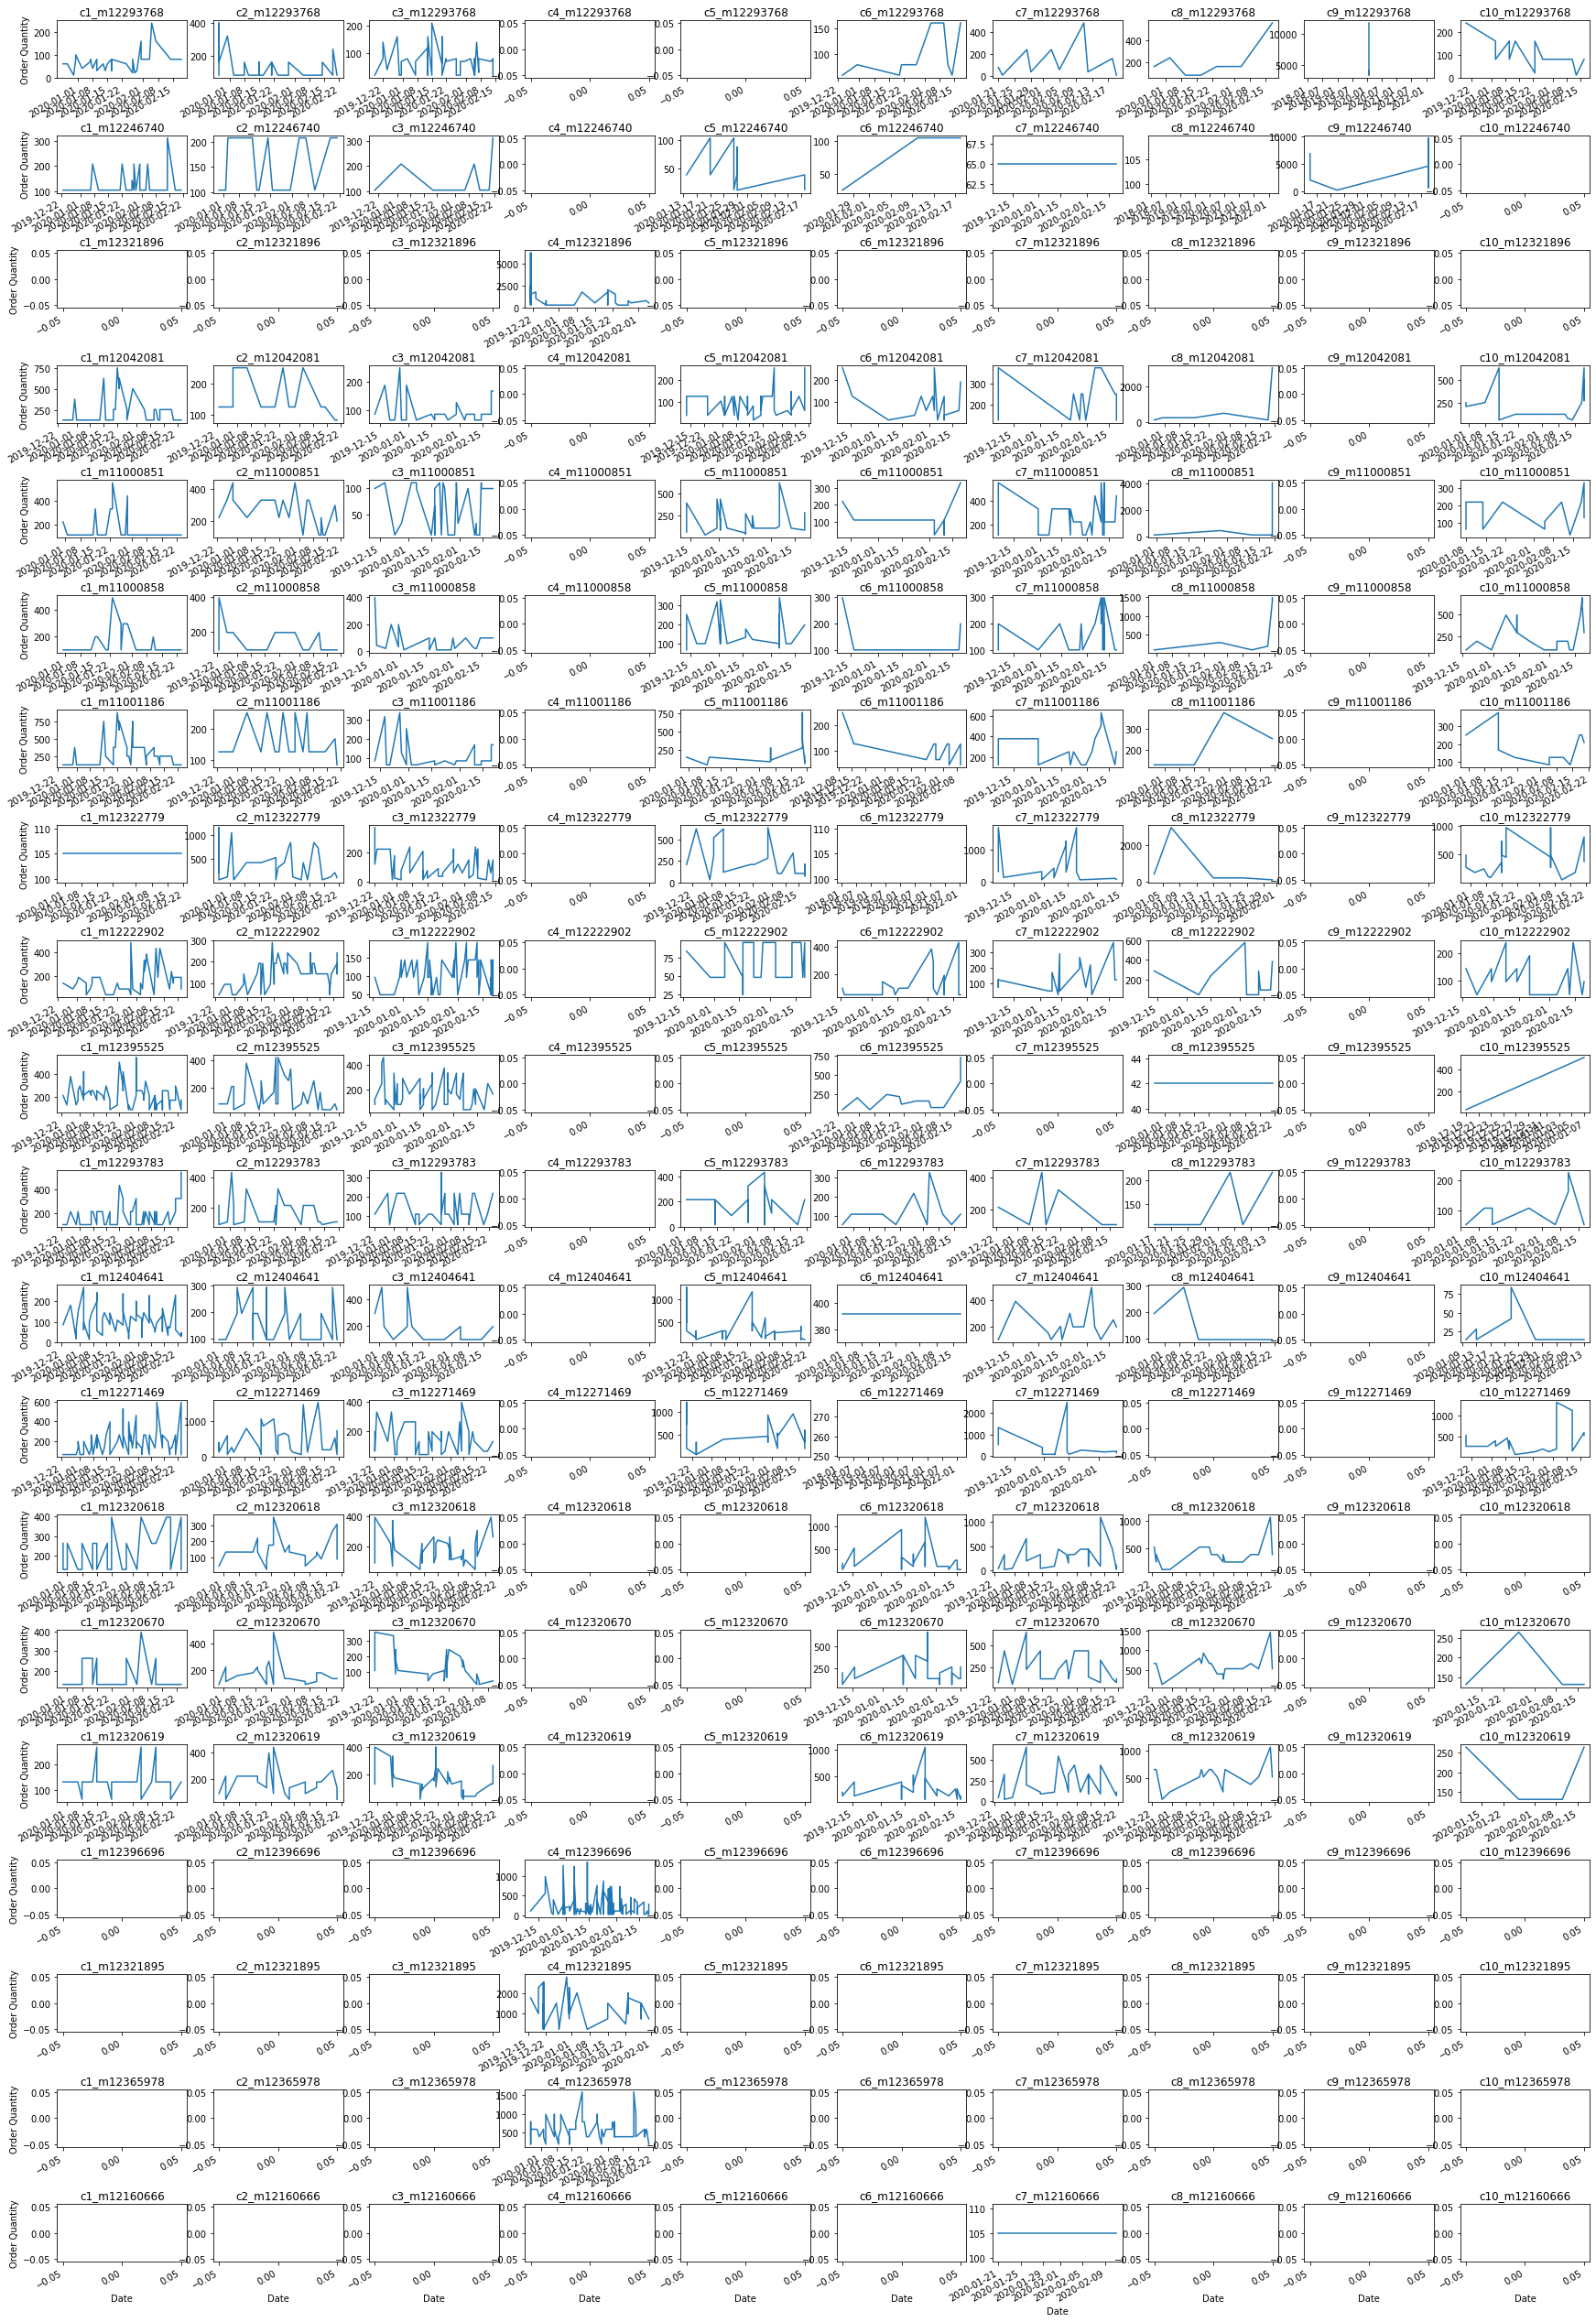

In [5]:
#both clients and materials are considered
names = locals()
figure, ax = plt.subplots(20, 10, figsize=(30, 50))
plt.subplots_adjust(hspace=1.0)

for i in range(20):
    names[material_list[i]] = df[df['Material'] == material_list[i]]
    for j in range(10):
        names['c'+str(j+1)+'_'+str(material_list[i])] = names.get(material_list[i])[names.get(material_list[i])['Client'] == 'c'+str(j+1)]
        axes = names.get('c'+str(j+1)+'_'+str(material_list[i])).plot(x = 'Date', y = 'Order Quantity', ax=ax[i, j], 
                                                                  legend=False, title='c'+str(j+1)+'_'+'m'+str(material_list[i]))
        if j == 0:
            axes.set_ylabel('Order Quantity')
        if i != 19:
            axes.xaxis.label.set_visible(False)
        if i == 19:
            axes.set_xlabel('Date')

Each row gives the order information for an individual material, while each column for an individual client. Luckily, the team can discover some intuitional rules through these graphs. Each client may just order some specific materials. The order quantity for some pairs of client and material seems to be regular. 

Overall, the dataset looks like time-series. To get prediction of specific pair of client-material, the team can simply treat each pair as a time-series problem, or consider the relationship between different pairs.

### 2.2. Data Preparation

Let's check the relationship between client and material first!

In [6]:
for i in client_list:
  sub_df=df[df['Client']==i]
  sub_m=sub_df['Material'].unique()
  num=len(sub_m)
  print(i)
  print(sub_m)
  print(num)

c9
[12293768 12246740]
2
c4
[12321896 12396696 12321895 12365978]
4
c3
[12042081 11000851 11000858 11001186 12222902 12246740 12293768 12395525
 12322779 12271469 12293783 12320619 12320618 12320670 12404641]
15
c2
[12246740 12222902 11001186 11000858 11000851 12042081 12322779 12271469
 12395525 12293768 12293783 12320618 12320619 12320670 12404641]
15
c8
[11000858 12322779 12293768 12222902 12395525 12293783 12404641 12042081
 11000851 12320670 12320619 12320618 11001186 12246740]
14
c10
[11000858 11001186 11000851 12042081 12222902 12271469 12293768 12395525
 12322779 12293783 12320619 12320670 12404641]
13
c6
[12395525 12322779 12293783 12404641 12320618 12320670 12320619 12042081
 11001186 11000851 11000858 12222902 12293768 12246740 12271469]
15
c5
[12246740 12042081 12293783 11001186 11000851 11000858 12222902 12404641
 12322779 12271469]
10
c7
[12293768 11001186 11000851 11000858 12042081 12222902 12404641 12246740
 12271469 12322779 12293783 12320670 12320619 12320618 12160666

In [7]:
for i in material_list:
  sub_df=df[df['Material']==i]
  sub_c=sub_df['Client'].unique()
  num=len(sub_c)
  print(i)
  print(sub_c)
  print(num)

12293768
['c9' 'c8' 'c7' 'c3' 'c10' 'c1' 'c6' 'c2']
8
12246740
['c9' 'c2' 'c3' 'c5' 'c7' 'c1' 'c6' 'c8']
8
12321896
['c4']
1
12042081
['c3' 'c10' 'c5' 'c7' 'c6' 'c8' 'c2' 'c1']
8
11000851
['c3' 'c10' 'c7' 'c6' 'c5' 'c8' 'c2' 'c1']
8
11000858
['c3' 'c8' 'c10' 'c7' 'c6' 'c5' 'c2' 'c1']
8
11001186
['c3' 'c10' 'c7' 'c5' 'c6' 'c2' 'c1' 'c8']
8
12322779
['c8' 'c6' 'c7' 'c5' 'c3' 'c2' 'c10' 'c1']
8
12222902
['c3' 'c2' 'c10' 'c7' 'c8' 'c6' 'c5' 'c1']
8
12395525
['c6' 'c8' 'c3' 'c10' 'c1' 'c2']
6
12293783
['c6' 'c5' 'c8' 'c3' 'c1' 'c7' 'c2' 'c10']
8
12404641
['c6' 'c7' 'c8' 'c5' 'c1' 'c3' 'c2' 'c10']
8
12271469
['c7' 'c5' 'c10' 'c3' 'c1' 'c2' 'c6']
7
12320618
['c6' 'c3' 'c8' 'c7' 'c2' 'c1']
6
12320670
['c6' 'c3' 'c8' 'c7' 'c2' 'c1' 'c10']
7
12320619
['c6' 'c3' 'c8' 'c7' 'c2' 'c1' 'c10']
7
12396696
['c4']
1
12321895
['c4']
1
12365978
['c4']
1
12160666
['c7']
1


Some duplicate data are found, and decided to sum order quantity for the same client, material and date to one order.

In [8]:
df2=df.groupby(['Date','Client','Material']).sum().reset_index()
df2['Date'] = pd.to_datetime(df2['Date']) 
df2.set_index(['Date'],inplace=True)    #we convert the date feature into date type, and set them as index

The team found a law of order quantity: for each type of material, the order quantities are always the integral multiple. Maybe the reason is that these materials are sold in batches.

Therefore, storing the relationship between quantity and batch for different materials might help.

In [9]:
#construct a dictionary storing the quantity of each batch
collection={}
for m in material_list:
  mdf=df[df['Material']==m]
  k=min(mdf['Order Quantity'].values)
  collection[m]=k

The team found the purchase behavior are discrete, which means clients do not set order everyday, but with some laws.

Therefore, the team wants to use a machine learning model to predict whether they will buy or not. To train the model, the team needs data of not order. Basing on each pair of client-material, the date line is complemented.

In [10]:
def add_zero(dataframe):
    dateline = pd.date_range(dataframe.index.min(), dataframe.index.max())
    dataframe=dataframe.reindex(dateline,fill_value=0)
    return dataframe
df3=pd.DataFrame()
for i in client_list:
  sub_df=df2[df2['Client']==i]
  sub_m=sub_df['Material'].unique()
  for j in sub_m:
    df_case=df2[(df2['Client']==i) & (df2['Material']==j)]
    df_case=add_zero(df_case)
    df_case['Client']=i
    df_case['Material']=j
    df3=df3.append(df_case)        ##df3 is dataset with record of non-order

With this new dataset, let's regenerate the graphs for each pair of client and material.

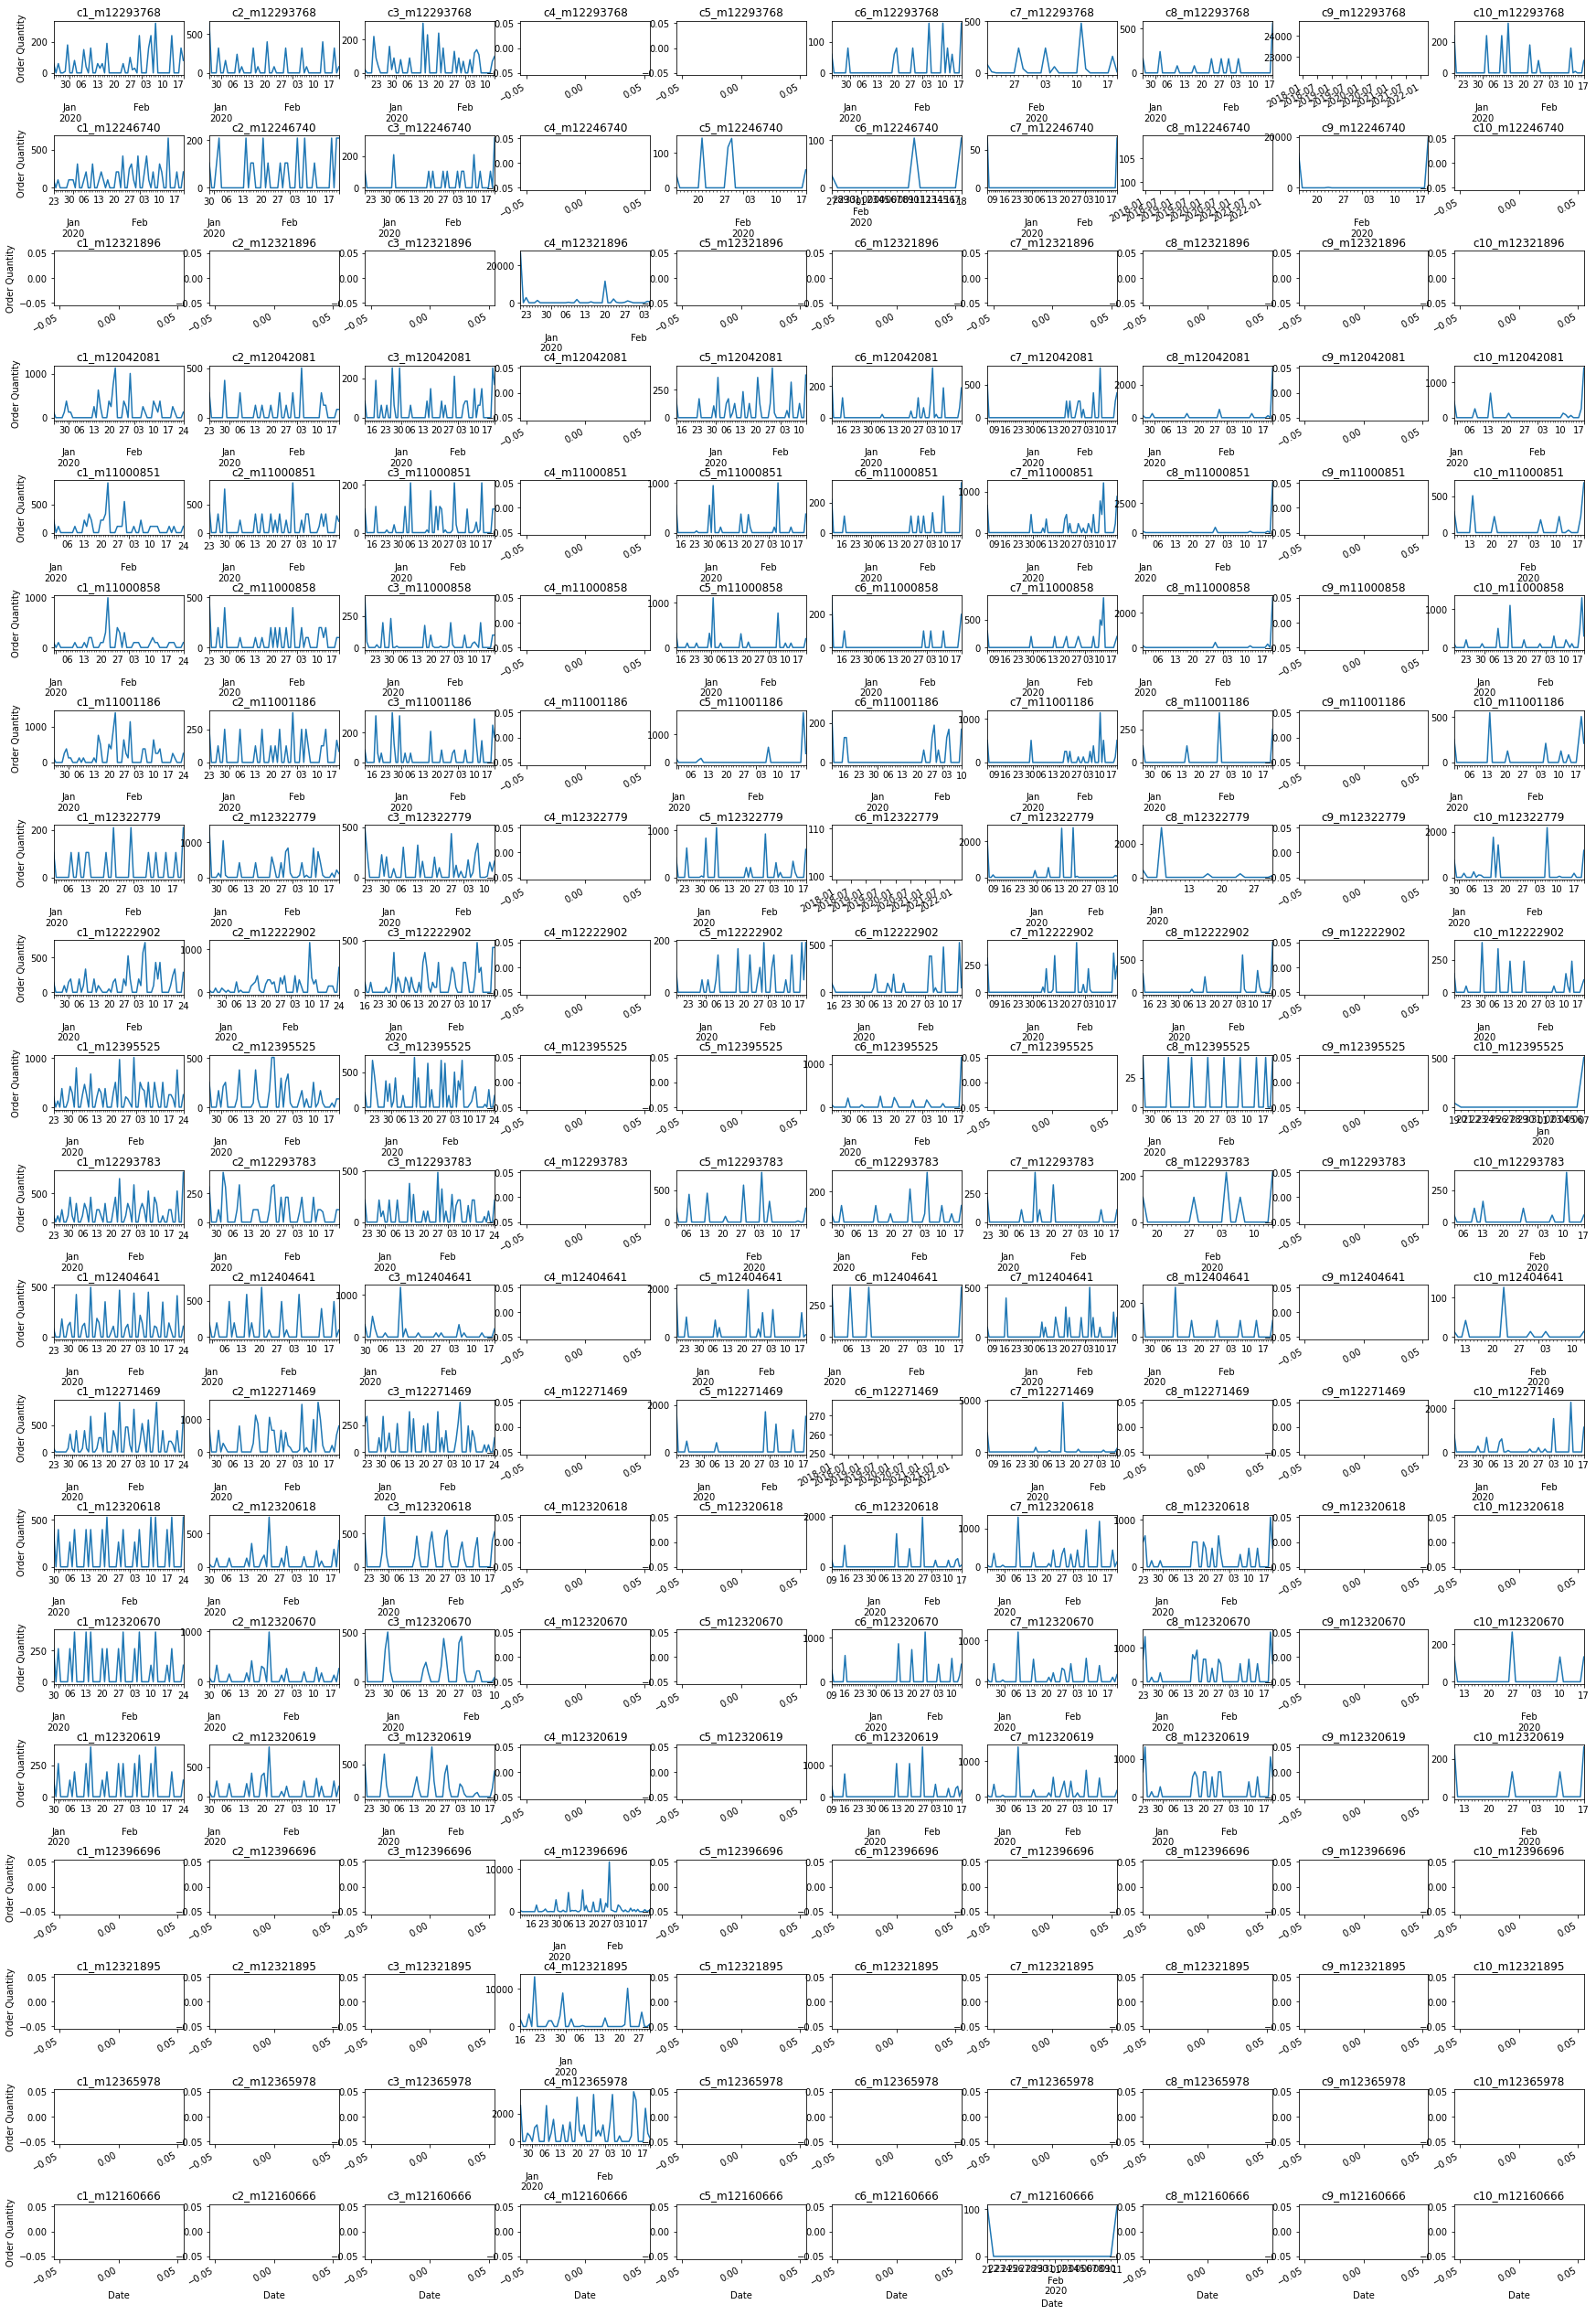

In [11]:
names = locals()
figure, ax = plt.subplots(20, 10, figsize=(30, 50))
plt.subplots_adjust(hspace=1.1)

for i in range(20):
    names[material_list[i]] = df3[df3['Material'] == material_list[i]]
    for j in range(10):
        names['c'+str(j+1)+'_'+str(material_list[i])] = names.get(material_list[i])[names.get(material_list[i])['Client'] == 'c'+str(j+1)]
        axes = names.get('c'+str(j+1)+'_'+str(material_list[i])).plot(y = 'Order Quantity', ax=ax[i, j], 
                                                                  legend=False, title='c'+str(j+1)+'_'+'m'+str(material_list[i]))
        if j == 0:
            axes.set_ylabel('Order Quantity')
        if i != 19:
            axes.xaxis.label.set_visible(False)
        if i == 19:
            axes.set_xlabel('Date')

The graphs are much better. It is clear that there are some regular order behaviors this time, such as periodicity. This dataset could be good to use for further predictions. 

## 3. Moving Average

### 3.1. Motivation

The team decides to use Moving Average as the first forecasting method. That is based on the observation of the dataset. Here are graphs for aggregate data, in which only clients or materials are taken into account. The team has shown the corresponding results of raw data in part 2, but in one figure. This time the team uses cleaned dataset and puts them in different figures.

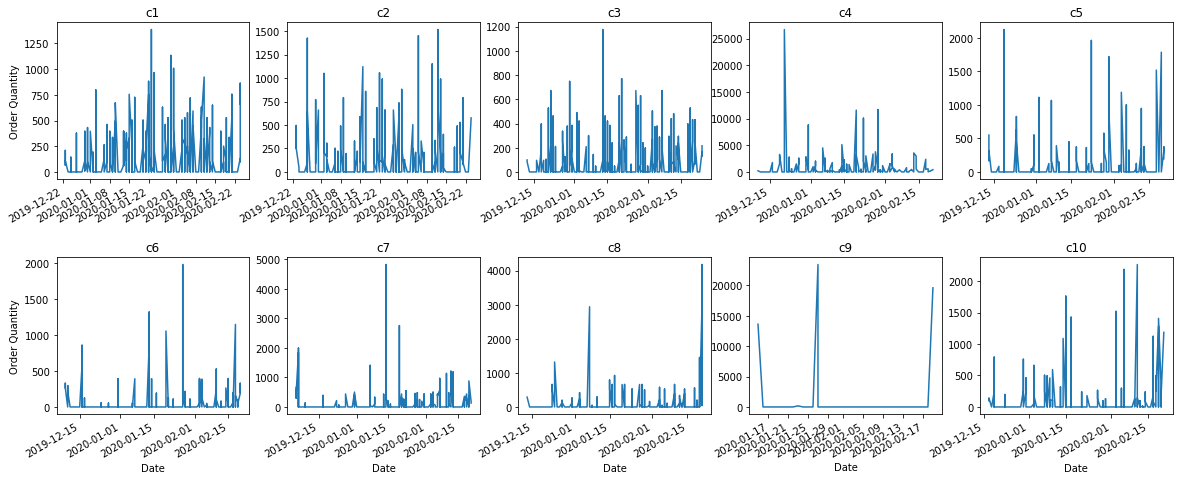

In [12]:
# materials not considered
# different clients in different figures
names = locals()
figure, ax = plt.subplots(2, 5, figsize=(20, 8))
plt.subplots_adjust(hspace=0.5)

for i in range(10):
    names['c' + str(i+1)] = df3[df3['Client'] == 'c' + str(i+1)]
    axes = names.get('c' + str(i+1)).plot(y='Order Quantity', ax=ax[i//5, i%5], legend=False, title="c"+str(i+1))
    if i%5 == 0:
        axes.set_ylabel('Order Quantity')
    if i//5 != 1:
        axes.xaxis.label.set_visible(False)
    if i//5 == 1:
        axes.set_xlabel('Date')

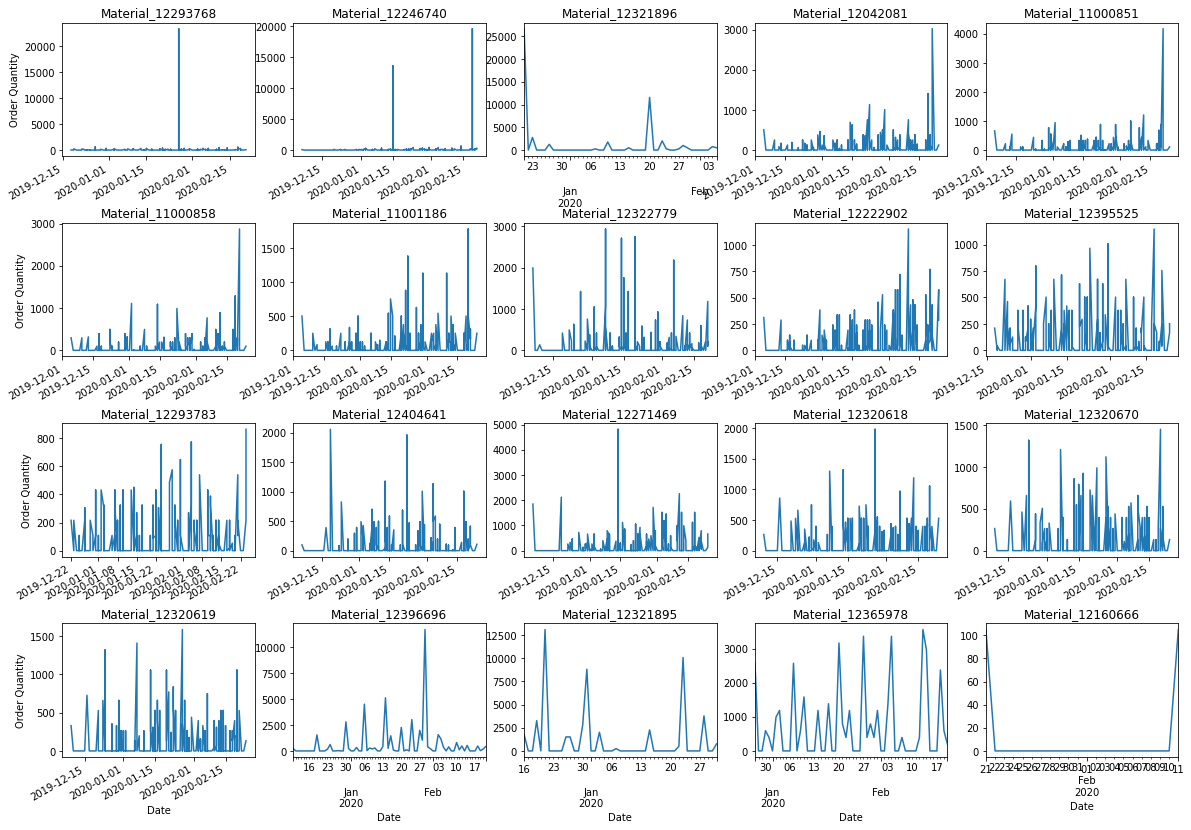

In [13]:
# clients not considered
# different materials in different figures
names = locals()
figure, ax = plt.subplots(4, 5, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

for i in range(20):
    names[material_list[i]] = df3[df3['Material'] == material_list[i]]
    axes = names.get(material_list[i]).plot(y='Order Quantity', ax=ax[i//5, i%5], 
                                            legend=False, title="Material_"+str(material_list[i]))
    if i%5 == 0:
        axes.set_ylabel('Order Quantity')
    if i//5 != 3:
        axes.xaxis.label.set_visible(False)
    if i//5 == 3:
        axes.set_xlabel('Date')

It can be seen that there is no obvious trend in these graphs. Although there are some "ridiculous" peaks, they just indicate that clients would make orders once in a while. In other words, no overall increase. Therefore, the team decides to take the data as stationary series, and that's why moving average has been appiled.

### 3.2. Forecasting

The team uses moving average to generate aggregate forecasts first. Then distribute aggregate forecasts by frequency to get individual forecasts.

#### 3.2.1. Client-Aggregate Forecast

The team doesn't consider clients and just predict the order quantity for different materials over date in this section.

The team uses a matrix (client x material) to record the total amount of a client's order on a material in the csv file. Then the distribution of material order quantity over clients is calculated.

In [14]:
names = locals()
client_distr = np.zeros([len(client_list), len(material_list)]) # client x material
for i in range(len(client_list)):
  curr_client = client_list[i]
  for j in range(len(material_list)):
    m = material_list[j]
    client_material = df[(df['Client'] == curr_client) & (df['Material']==m)]
    client_distr[i][j] = client_material['Order Quantity'].sum()

material_to_ind = {material_list[i]:i for i in range(len(material_list))}
client_to_ind = {client_list[i]:i for i in range(len(client_list))}
client_distr = client_distr / client_distr.sum(axis=0)

Recall the formula of moving average method: 

$$F_{t+1}=\frac{1}{N}(D_{t}+D_{t-1}+...+D_{t-N+1})$$

With this formula, the team calculates the moving average of the total amount of a material over a specific time period which has been called "windowlen" in codes. It is the "N" in moving average method. 

In [15]:
# either the actual record or predicted moving avgerage has been inserted to df
def moving_avg_material(indate, materials, windowlen, df):
  counts = 0
  for i in range(1, windowlen+1):
    currdate=indate - pd.DateOffset(days=i)
    selected = df[(df['Date']==currdate) & (df['Material']==materials)]
    counts += selected['Order Quantity'].sum()
  ma = counts/windowlen
  return ma

So the team has the method function. But the best N has to be determined before using the function. The following part is for fine-tuning an approriate N, the last 12 days of the data (around 15%) were chosen as test cases, and a predicted order quantity for each material is calcuated by applying different N. The best N is chosen as the one that achieves the minimum MSE over date and material.

In [16]:
startdate = df['Date'].min()
enddate = df['Date'].min()+pd.DateOffset(days=81)
numdays = 82
testdays = 12 # 82 * 15%
lmse1 = []
for windowlen in range(1, 61):
  list_error = np.zeros([testdays, len(material_list)]) # days x material
  daycount = 0
  for i in range(numdays-testdays, numdays):
    indate = startdate+pd.DateOffset(days=i)
    for j in range(len(material_list)):
      material = material_list[j]
      ma = moving_avg_material(indate, material, windowlen, df)
      actual = df[(df['Date']==indate) & (df['Material']==material)]['Order Quantity'].sum()
      list_error[daycount][j] = (ma-actual)**2
    daycount+=1
  mse = list_error.flatten().mean()
  print(windowlen, mse)
  lmse1.append(mse)

1 3805711.1958333333
2 3005130.2114583333
3 2788849.987037036
4 2641345.681510417
5 2511396.240333333
6 2376634.4886574075
7 2270712.029676871
8 2205146.986328125
9 2155131.692746913
10 2129219.5629166667
11 2123617.107575758
12 2129668.5755787035
13 2120406.0249013803
14 2091848.4879676872
15 2069087.9652962962
16 2068355.0044759114
17 2081980.800821799
18 2086940.7616512345
19 2103958.137430748
20 2114270.47453125
21 2112175.948790627
22 2092157.1715392559
23 2092030.9202977314
24 2100557.2567853006
25 2110247.367473333
26 2123905.598280325
27 2128749.3427069043
28 2124142.627279975
29 2113905.7341706296
30 2111355.8757268516
31 2114597.4103668057
32 2120270.570576986
33 2127625.1289791856
34 2126957.922404845
35 2055331.417064626
36 2052077.1515335653
37 2050020.3055088872
38 2051162.235869691
39 2057074.3235371464
40 2063989.9157552079
41 2066069.3879412056
42 2060555.6569562543
43 2057832.8679376235
44 2058245.856876291
45 2058252.207092593
46 2059640.4302418088
47 2061049.0399068

Then the best N can be retrieved by finding the index of minimum MSE. Note that the best N is that index plus 1.

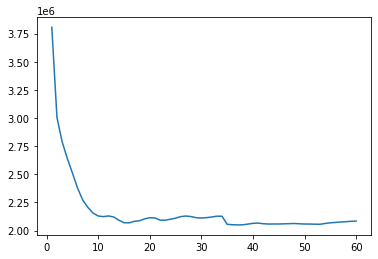

In [17]:
#find the best N
plt.plot(range(1,61), lmse1)
N_best_m = lmse1.index(min(lmse1))+1

In [18]:
N_best_m

37

Set windowlen as the best N. The team can make predictions now. For future dates, pre-calculate and record the moving averages as a read-ready lookup table. 

For moving average method, the team uses the last forecast as well as the most recent observation to make predictions. As a result, it will take more time to forecast as the future date goes further. Therefore, the team sets the maximum future days as 100 and save the predictions in a table. Users can get the predictions within 100 future days immediately. If a user wants to see the predictions for further future dates, just change the value of "max_future_m".

By the way, although the team has already found the best N, it is also changeable. The users can set its own N by changing the value of "windowlen".

In [19]:
# build a moving average table to include results from both past records and future predictions
windowlen = N_best_m
max_future_m = 100
datenow = df['Date'].max()
dfpredict_m = pd.DataFrame.copy(df)

#datenow = testdate = indate + pd.DateOffset(days=16)
for d in range(1,max_future_m):
  future_date = datenow + pd.DateOffset(days=d)
  for i in range(len(material_list)):
    material = material_list[i]
    ma = moving_avg_material(future_date, material, windowlen, dfpredict_m)
    for j in range(len(client_list)):
      client = client_list[j]
      df_m = pd.DataFrame([[future_date, client, client_distr[j][i] * ma, material]], 
                         columns =  ["Date", "Client", "Order Quantity", "Material"])
      dfpredict_m = pd.concat([dfpredict_m, df_m])

#### 3.2.2. Material-Aggregate Forecast

The team doesn't consider materials and just predict the order quantity for different clients over date in this section. The procedure is exactly the same as 3.2.1. Hence there is no more explanations in this section. 

In [20]:
client_distr = np.zeros([len(client_list), len(material_list)]) # client x material
for i in range(len(client_list)):
  curr_client = client_list[i]
  for j in range(len(material_list)):
    m = material_list[j]
    client_material = df[(df['Client'] == curr_client) & (df['Material']==m)]
    client_distr[i][j] = client_material['Order Quantity'].sum()

material_to_ind = {material_list[i]:i for i in range(len(material_list))}
client_to_ind = {client_list[i]:i for i in range(len(client_list))}
client_distr = (client_distr.T / client_distr.sum(axis=1)).T

In [21]:
def moving_avg_client(indate, client, windowlen, df):
  counts = 0
  for i in range(1, windowlen+1):
    currdate=indate - pd.DateOffset(days=i)
    selected = df[(df['Date']==currdate) & (df['Client']==client)]
    counts += selected['Order Quantity'].sum()
  ma = counts/windowlen
  return ma

In [22]:
lmse2 = []
for windowlen in range(1, 61):
  list_error = np.zeros([testdays, len(client_list)]) # days x client
  daycount = 0
  for i in range(numdays-testdays, numdays):
    indate = startdate+pd.DateOffset(days=i)
    for j in range(len(client_list)):
      client = client_list[j]
      ma = moving_avg_client(indate, client, windowlen, df)
      actual = df[(df['Date']==indate) & (df['Client']==client)]['Order Quantity'].sum()
      list_error[daycount][j] = (ma-actual)**2
    daycount+=1
  mse = list_error.flatten().mean()
  print(windowlen, mse)
  lmse2.append(mse)

1 9645501.391666668
2 7862658.572916667
3 7265516.333333332
4 6875894.981770833
5 6585974.991333334
6 6226891.43287037
7 5907605.794387755
8 5720897.337239583
9 5634913.9597736625
10 5598774.620166666
11 5587424.803030304
12 5614761.023148148
13 5593633.71607495
14 5485403.3320578225
15 5412828.625777777
16 5374624.46233724
17 5418981.325346021
18 5480016.998045268
19 5540205.902285318
20 5553650.991895834
21 5508776.444444444
22 5488596.339772728
23 5191272.8618935095
24 5254504.464988425
25 5311056.24788
26 5391927.827970907
27 5452567.707293095
28 5460910.560406038
29 5451822.698820849
30 5472731.623064815
31 5508761.955038155
32 5547540.2401285805
33 5579756.58651668
34 5593492.525836217
35 5433444.96377551
36 5411427.751408178
37 5396328.036523009
38 5408782.085289705
39 5425452.483355249
40 5443571.830072916
41 5447974.4596619075
42 5415907.6576294415
43 5404959.126401658
44 5392664.799005683
45 5372348.042860082
46 5380670.128954
47 5393022.615780142
48 5402914.398564091
49 5384

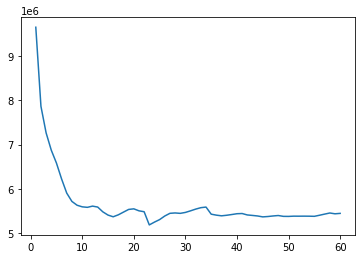

In [23]:
#find the best N
plt.plot(range(1,61), lmse2)
N_best_c = lmse2.index(min(lmse2))+1

In [24]:
N_best_c   ##the best N is different

23

In [25]:
# build a moving average table to include results from both past records and future predictions
windowlen = N_best_c
max_future_c = 100
dfpredict_c = pd.DataFrame.copy(df)

#datenow = testdate = indate + pd.DateOffset(days=16)
for d in range(1,max_future_c):
  future_date = datenow + pd.DateOffset(days=d)
  for j in range(len(client_list)):
    client = client_list[j]
    ma = moving_avg_client(future_date, client, windowlen, dfpredict_c)
    for i in range(len(material_list)):
      material = material_list[i]
      df_c = pd.DataFrame([[future_date, client, client_distr[j][i] * ma, material]],  columns =  ["Date", "Client", "Order Quantity", "Material"])
      dfpredict_c = pd.concat([dfpredict_c, df_c])

#### 3.2.3. Individual Forecast

The results of individual forecast have already been stored in the previous prediction tables, namely "dfpredict_m" and "dfpredict_c". Note that they are the **SAME** dateframes. Thus, when showing final predictions, either of them is fine. 

In [26]:
dfpredict=dfpredict_m.groupby(['Date','Client','Material']).sum().reset_index()
dfpredict  ##all predictions within 100 future days are saved in this dataframe

,Date,Client,Material,Order Quantity
0,2019-12-05,c7,11000851,660.0
1,2019-12-05,c7,11000858,297.0
2,2019-12-05,c7,11001186,504.0
3,2019-12-05,c7,12042081,504.0
4,2019-12-05,c7,12222902,312.0
...,...,...,...,...
21487,2020-06-02,c9,12322779,0.0
21488,2020-06-02,c9,12365978,0.0
21489,2020-06-02,c9,12395525,0.0
21490,2020-06-02,c9,12396696,0.0


### 3.3. Final Solution

In [27]:
def forecast(date,client,material):
  try:
      date=pd.to_datetime(date)
  except:
      return 'wrong date'
  if client=='':
      material=int(material)
      material_predict = dfpredict[(dfpredict['Date']==date)&(dfpredict['Material']==material)]
      return material_predict['Order Quantity'].sum()
  elif material=='':
      client_predict = dfpredict[(dfpredict['Date']==date)&(dfpredict['Client']==client)]
      return client_predict['Order Quantity'].sum()
  else:
      material=int(material)
      predict = dfpredict[(dfpredict['Date']==date)&(dfpredict['Material']==material)&(dfpredict['Client']==client)]
      return predict['Order Quantity'].sum()    

### 3.4. Explanation of Results

The biggest problem for this method is "date division". As the team has shown in 3.1, clients make orders every now and then and the variance is high. But when the team divides total demand by N, order quantity is averaged to these N days actually. That would make the predictions less than normal order quantity. The variance of predictions is much less than it of the dataset. As a representative instance, let's have a look at c7 and m12160666.

In [28]:
dfpred_m12160666=dfpredict[(dfpredict['Date']==datenow+pd.DateOffset(days=1))&(dfpredict['Material']==12160666)]
dfpred_m12160666

,Date,Client,Material,Order Quantity
1696,2020-02-25,c1,12160666,0.000000
1716,2020-02-25,c10,12160666,0.000000
1736,2020-02-25,c2,12160666,0.000000
1756,2020-02-25,c3,12160666,0.000000
1776,2020-02-25,c4,12160666,0.000000
1796,2020-02-25,c5,12160666,0.000000
1816,2020-02-25,c6,12160666,0.000000
1836,2020-02-25,c7,12160666,5.675676
1856,2020-02-25,c8,12160666,0.000000
1876,2020-02-25,c9,12160666,0.000000


It seems that c7 will order 5.68 goods of m12160666 on 2020-02-25 according to the method. But what do the real orders look like? 

In [29]:
df[df['Material'] == 12160666]

,Date,Client,Order Quantity,Material
1258,2020-01-21,c7,105,12160666
2303,2020-02-11,c7,105,12160666


c7 ordered 105 goods every time! That makes the forecast seem weird. But actually, the result is rather reasonable in three ways.

First, c7 was the only client for m12160666 and he/she made only two orders in all. But there are more than 2700 orders in the dataset. This result indicates that **almost nobody will buy m12160666 on 2020-02-25**. If the order quantity and frequency changes sometime in the future, the forecast result will change therewith.

Second, this result gives a **production strategy** to the manufacturer, **which he/she should produce 5.68 goods on that day**. It can be imagined that c7 will order another 105 in the future, but the exact time is not known. If the team just focus on the next order date, the uncertainty can be extremely large and hence increase the loss. This result gives a way to reduce the loss, which is of great practical significance.

Third, this result **implies the next order date**. To make productions by following the predictions day by day, the date when the manufacturer accumulates 105 goods is the most likely date which c7 will make another order, according to the method. To get an impression of this, suppose the manufacturer produces 5.68 goods everyday. He/She will get 105 goods 19 days later. As can be seen in the previous cell, the time interval between the only two orders is 21 days. The prediction is very close to the real situation.

## 4. Machine Learning

### 4.1. Summary

Reasons that ML method is chosen:

After visualizing the dataset, the team found something:
1. The features include date client and material, if the team just 
considers records with same client and material, data are limited.
And dates are discrete.
2. Client and material have strong relation, different client have 
different preference. So their buying list are fixed.
3. The quantity data are stationary, with some seasonal factor.
Alhough they have large range, there is no clear trend along date.

As a result, it is reasonable not to treat it as pure time-series problem,
but the team should focus more on the relationship between quantity and
client/material.

Therefore ML method is selected to predict, taking advantage of features
of client and material, while convert date feature into seasonal
factor. More details of data treatment are below.

In the pipeline: 

1.The team firstly uses classify model to predict if client will buy.
 To train model,  the team adds records of not-buy, see in data preparing
 section. Considering interests of store, the team tends to find all potential buying
 records,which means the team should evaluate model by recall score.

2.Then use regression model to predict the quantity.
 Since the team does regression basing on knowing they will buy,
 the model is trained only by original data(buying records).
 Model is evaluated by RMSE.

3.Both two models are selected from many alternative models and 
grid search method to get best hyper-parameters.

### 4.2. Feature Engineering

Since the team decided not to treat the dataset as normal time-series problem, the team converted the date feature into more specific features: weekday; week of year; day of year and so on.

In [30]:
#Sorting
df4=df3.sort_index(axis=0)
#Feature Engineering
df4['Day of Week']=df4.index.dayofweek
df4['Month_start']=df4.index.is_month_start
df4['Month_end']=df4.index.is_month_end   ##df4 is the dataset with date features

Converting the quantity into number of batches could let the curve more smooth and help to predict.

In [31]:
#define the function to convert quantity into number of parts
def intobatch(row):
  num=collection[row['Material']]
  return row['Order Quantity']/num
df4['batch']=df4.apply(intobatch,axis=1)

Finally, to fit the data into machine learning model, category data needs to be converted into dummy data.

In [32]:
df5 = pd.get_dummies(df4, columns = ['Client','Material','Day of Week','Month_start','Month_end'])
##df5 is the dataset after dummy, ready to be fitted into ML model

### 4.3. Model for Classification

For prediction of consumers' bebavior, the team creates new feature 'order_or_not', which represents if the order quantity in record is zero or not.

In this section, the teawm simply train model to predict if consumer will buy--no matter how much they buy.

In [33]:
df5['order_or_not']=df5.apply(lambda row: 0 if row['batch']==0 else 1,axis=1)

#### 4.3.1. Model Preparing

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE

The data has been split into training and test sets, with an 70-30 split.

In [35]:
X=df5.drop(columns=['Order Quantity', 'batch','order_or_not'])
y=df5['order_or_not']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [36]:
# Possible model candidates 
Cmodel_params = {
    
    'Logistic_Regression' : {
        'model': LogisticRegression(),
        'params': {
        }
    },
    
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors':list(range(3,10)),
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size':list(range(20,40))
        }
    },
    
    'SVM': {
        'model': SVC(),
        'params' : {
           
            'C': [0.5,1,5,10,20,30,50],
            'degree': [2,3,4],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }  
    },
    
    'Decision Trees' : {
        'model': DecisionTreeClassifier(),
        'params': {
            "max_depth" : [None,2,5,8,10,15,20,30,40],
            "max_features"  : ["sqrt", "log2", "auto",None],
            "min_samples_split":[2,5,10,15,20,30,50,100],
            "min_samples_leaf": [5,10,30,40,50,100]  
        }
    },
       
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators' : [2,5,10,50,100,200],
            'max_depth': [10,50,100,200,None],
            "min_samples_split":[2,5,10,15,20,30,50,100],
            'min_samples_leaf':[1,2,5,10,30,40,50,100]
        }
    },
    
    'Naive Bayes' : {
        'model': MultinomialNB(),
        'params': {
            
        }
    },   
}

#### 4.3.2. Model Comparing

From the dataset with adding-zero, it is found that the data is imbalance, which means
in most days clients do not order. The records of order are 1/3 of
records of not order.

Thinking from store's perspective, recall score is chosen as their
measurement, which means the team tries their best to capture their buying
behavior.

In [37]:
scores = []
for model_name, mp in Cmodel_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_iter=15, scoring='recall')
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    recall=recall_score(y_test,y_pred)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'recall': recall
    })
    print('This is model {}.'.format(model_name))
print()    
comp1 = pd.DataFrame(scores,columns=['model','best_score','best_params','recall'])
comp1

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


This is model Logistic_Regression.
This is model KNN.
This is model SVM.
This is model Decision Trees.
This is model Random Forest.
This is model Naive Bayes.



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


,model,best_score,best_params,recall
0,Logistic_Regression,0.333309,{},0.370143
1,KNN,0.545228,"{'n_neighbors': 3, 'leaf_size': 21, 'algorithm...",0.543967
2,SVM,0.546027,"{'kernel': 'poly', 'degree': 4, 'C': 5}",0.578732
3,Decision Trees,0.374917,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.394683
4,Random Forest,0.511141,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.552147
5,Naive Bayes,0.258506,{},0.290389


In [38]:
comp1['best_params'][1]

{'algorithm': 'auto', 'leaf_size': 21, 'n_neighbors': 3}

From the result table of models, the best classification model is KNN. Best parameters:'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 5.

The results are different as each runtime, but KNN is a model with
stable performance, which is always around 0.58



In [39]:
final_model1=KNeighborsClassifier(algorithm='auto', leaf_size= 20, n_neighbors= 5)

### 4.4. Model for Regression

After confirming that consumer would order, the team needs to predict their order quantity, which uses the regression model. Note that the team only predicts the quantity when they decide to buy, so the dataset for use will exclude zero record.

Just do the same treatment to dataset before adding zero.

In [40]:
#Sorting
df6=df2.sort_index(axis=0)
#Feature Engineering
df6['Day of Week']=df6.index.dayofweek
df6['Month_start']=df6.index.is_month_start
df6['Month_end']=df6.index.is_month_end
##df6 is the dataset with date features
##define the function to convert quantity into number of parts
def intobatch(row):
  num=collection[row['Material']]
  return row['Order Quantity']/num
df6['batch']=df6.apply(intobatch,axis=1)
df6 = pd.get_dummies(df6, columns = ['Client','Material','Day of Week','Month_start','Month_end'])
##now df6 is the dataset after dummy, ready to be fitted into ML model

Again, split the dataset.

In [41]:
X2=df6.drop(columns=['Order Quantity', 'batch'])
y2=df6['batch']
x_train, x_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=3)

#### 4.4.1. Model Preparing

In [42]:
# Possible model candidates 
model_params = {
    
    'Linear_Regression' : {
        'model': LinearRegression(),
        'params': {
        }
    },
    
    'KNN': {
        'model': KNeighborsRegressor(n_jobs=-1),
        'params': {
            'n_neighbors':list(range(1,10)),
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size':list(range(20,40))
        }
    },
    
    'SVR': {
        'model': SVR(),
        'params' : {
            #'gamma':['scale','auto'],
            'C': [0.5,1,5,10,20,30,50],
            'degree': [2,3,4]
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }  
    },
    
    'Decision Trees' : {
        'model': DecisionTreeRegressor(),
        'params': {
            "max_depth" : [None,2,5,8,10,15,20,30,40],
            "max_features"  : ["sqrt", "log2", "auto",None],
            "min_samples_split":[2,5,10,15,20,30,50,100],
            "min_samples_leaf": [5,10,30,40,50,100]  
        }
    },
       
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators' : [2,5,10,50,100,200],
            'max_depth': [10,50,100,200,None],
            "min_samples_split":[2,5,10,15,20,30,50,100],
            'min_samples_leaf':[1,2,5,10,30,40,50,100]
        }
    },
    
    'XGBoost' : {
        'model': XGBRegressor(),
        'params': {
            #"booster": ['gbtree', 'gblinear','dart'],
            "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
            'reg_alpha':[1e-5, 1e-2, 0.1, 1,5, 10, 100]
            
        }
    },   
}

In [43]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

#### 4.4.2. Model Comparing

In [44]:
scores = []
for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_iter=15, scoring='neg_root_mean_squared_error')
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    mse=MSE(y_test,y_pred)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'RMSE': np.sqrt(mse)
    })
    print('This is model {}.'.format(model_name))
print()    
comp = pd.DataFrame(scores,columns=['model','best_score','best_params','RMSE'])
comp

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


This is model Linear_Regression.
This is model KNN.
This is model SVR.
This is model Decision Trees.
This is model Random Forest.
[03:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of

,model,best_score,best_params,RMSE
0,Linear_Regression,-45.323967,{},28.447264
1,KNN,-66.267476,"{'n_neighbors': 7, 'leaf_size': 27, 'algorithm...",47.899887
2,SVR,-65.622708,"{'degree': 2, 'C': 30}",56.094020
3,Decision Trees,-66.290620,"{'min_samples_split': 10, 'min_samples_leaf': ...",56.373258
4,Random Forest,-45.345689,"{'n_estimators': 100, 'min_samples_split': 5, ...",27.145172
5,XGBoost,-50.217256,"{'reg_alpha': 0.1, 'min_child_weight': 1, 'max...",33.470704


Therefore, the best model is Linear Regression.

In [45]:
final_model2=LinearRegression()

### 4.5. Final Solution

In [46]:
X=df5.drop(columns=['Order Quantity', 'batch','order_or_not'])
y=df5['order_or_not']
final_model1.fit(X,y)
X2=df6.drop(columns=['Order Quantity', 'batch'])
y2=df6['batch']
final_model2.fit(X2,y2)             # fit the final model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
def treatment(date,client,material):##This function converts the input for model
  forcast=pd.DataFrame(columns=['Client','Material','Day of Week','Month_start','Month_end'])
  try:
    date=pd.to_datetime(date)
  except:
    return "wrong date"
  forcast['Client']=[client]
  forcast['Material']=[material]
  forcast['Day of Week']=[date.dayofweek]
  forcast['Month_start']=[date.is_month_start]
  forcast['Month_end']=[date.is_month_end]
  forcast = pd.get_dummies(forcast, columns = ['Client','Material','Day of Week','Month_start','Month_end'])
  forcast = forcast.reindex(columns = X.columns, fill_value=0)
  return forcast
def clf_solution(forcast):#classify model
  pred=final_model1.predict(forcast)
  return pred
def rgr_solution(forcast):#regression model
  pred=final_model2.predict(forcast)
  return pred

In [48]:
def predict_case(date,client,material):#this function predict special pair of client and material
  material=int(material)
  if client not in client_list or material not in material_list:
    print('invalid input')
    return 0
  sub_df=df[df['Client']==client]
  sub_m=sub_df['Material'].unique()
  if material not in sub_m:
    print("the client doesn't order this material")
    return 0
  forcast=treatment(date,client,material)
  if clf_solution(forcast)==0:
    print("he won't order that day")
    return 0
  else:
    batch_size=collection[material]          #convert number of batches back to quantity
    return rgr_solution(forcast)*batch_size

In [49]:
def predict(date,client,material):# this function is main function for predict
  if client=='':
    sum=0
    for i in client_list:
      sum=sum+predict_case(date,i,material)
    return ('final aggregate number:',sum)
  elif material=='':
    sum=0
    for i in material_list:
      sum=sum+predict_case(date,client,i)
    return ('final aggregate number:',sum)    ## if input of client or material is ' ', the aggregation number is returned
  else:
    return predict_case(date,client,material)

## 5. Interactive

In this section, input date, client and material by steps and get result.Date format is 2020-03-05.

If the user wants the aggregate number, directly click 'enter' in client or material label.

Note: For moving method avgerage method, a prediction can only be may up to 2020-06-03. This is because the moving average method only forecasts 100 days from the last day in the provided data, 2020-02-24. To produce a further moving average forecast, user can change the variable max_future_m or max_future_c from 100 to a larger number.

In [52]:
#moving average predictions
date = input('date(format like 2020-03-05):')
client = input('client:')
material = input('material:')
forecast(date,client,material)

date(format like 2020-03-05):2020-03-05
client:c4
material:11001186


0.0

In [53]:
#machine learning predictions
date = input('date(format like 2020-03-05):')
client = input('client:')
material = input('material:')
predict(date,client,material)

date(format like 2020-03-05):2020-03-05
client:c4
material:11001186
the client doesn't order this material


0

## 6. Bonus Method (Fbprophet Forecasting Application)

Out of curiosity, another method has been exploited. Fbprophet is a forecasting model developed by FaceBook where it manipulate time series data to make forecasting based on an additive model with which non-linear trends are fit with yearly, weekly, daily seasonality as well as holiday effects. It performs the best with time series that have strong seasonal effects and several seasons of historical data. However, not all cases exhibit such features. Therefore, the forecasting results maybe better or worse than other methods depending on the particular case selected. In this bonus section, one single case from dataset has been used to demonstrate the process of utilization of Fbprophet on demand forecast in supply chain management. 

In [54]:
import matplotlib.dates as mdates
try:
    from fbprophet import Prophet
except:
    !pip install pystan
    !pip install fbprophet 
    from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools
import json
from datetime import datetime as dt
try:
    import ipywidgets as widgets
except:
    !pip install ipywidgets
    import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

### 6.1. Data Processing

Fbprophet requires users to organize data into certain format in order to be fit into model properly. The basic column are 'ds' containing date and 'y' containing quantity respectively. 

In [55]:
# Create datesets for fbProphet model
df_fb=df3.reset_index()
df_fb.rename(columns={'index':'Date'},inplace=True)
df_fb['Date']=df_fb['Date'].astype('str')
df_fb['Material']=df_fb['Material'].astype('str')
df_fb.head()

,Date,Client,Material,Order Quantity
0,2020-01-15,c9,12246740,13610
1,2020-01-16,c9,12246740,0
2,2020-01-17,c9,12246740,0
3,2020-01-18,c9,12246740,0
4,2020-01-19,c9,12246740,0


In [56]:
# Create client and material list consisting of unique items respectively 
Client_ls=list(df_fb['Client'].unique())
Material_ls=list(df_fb['Material'].unique())

In [57]:
# Create client and material selector widget for user-interactivity purpose
## All the interative information need to be re-run to appear!
client=widgets.Select(
    options=Client_ls,
    value='c4',
    description='Client',
    disabled=False
)
material=widgets.Select(
    options=Material_ls,
    value='12365978',
    description='Material',
    disabled=False
)

def case_interested (client,material):
    cases=df_fb[(df_fb['Client']==client)&(df_fb['Material']==material)]
    return cases
cases=widgets.interactive(case_interested,client=client, material=material)

In [58]:
# Instructions:
# Firstly select 'Client' and 'Material' from dropdowns respectively, then re-run this cell to update the output and run subsequent cells
# If there is no information, please try other combinations because it indicates that particular case does not exist
# Since the program in the optimization section consumes large amount of time, it is suggested to pick case with small datasets

display(cases)
cases.result.head()

interactive(children=(Select(description='Client', index=1, options=('c9', 'c4', 'c3', 'c2', 'c8', 'c10', 'c6'…

,Date,Client,Material,Order Quantity
205,2019-12-27,c4,12365978,2574
206,2019-12-28,c4,12365978,0
207,2019-12-29,c4,12365978,0
208,2019-12-30,c4,12365978,594
209,2019-12-31,c4,12365978,396


Text(0.5, 1.0, 'Historical Data for c4 & 12365978')

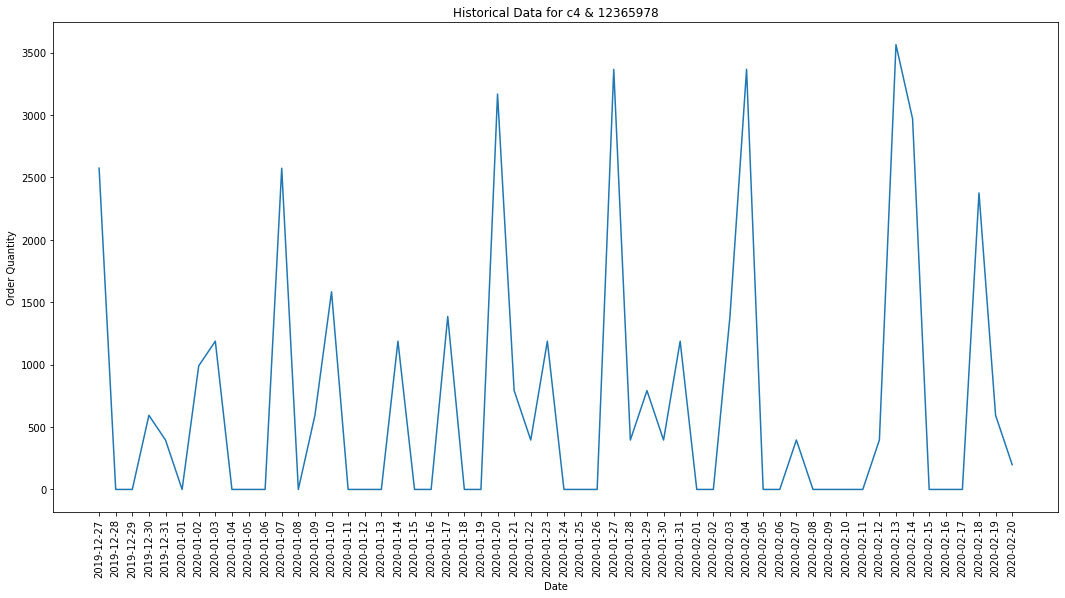

In [59]:
# Plot historical data for particular case as reference 
case=cases.result
Client=case['Client'].iloc[0]
Material=case['Material'].iloc[0]
plt.figure(figsize=(18,9))
plt.plot(case['Date'],case['Order Quantity'])
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Order Quantity')
plt.title('Historical Data for {} & {}'.format(Client,Material))

In [60]:
# Change pertinent column names to the ones accepted by Prophet 
case.rename(columns={'Date':'ds','Order Quantity':'y'},inplace=True)

In [61]:
# Extract key attribures required for Prophet 
case_standard=case[['ds','y']]
case_standard.head()

,ds,y
205,2019-12-27,2574
206,2019-12-28,0
207,2019-12-29,0
208,2019-12-30,594
209,2019-12-31,396


### 6.2. Model Evaluation

Fbprophet allows users to change some parameters to adjust the strength in terms of trend and seasonal flexibility. Holiday effects are also available to tune. However, for dataset in this project, trend and seasonality are the main concerns. Therefore, these will be the major parameters to be tuned for this particular model. RMSE will be used as the metric to compare against different models. 

In [62]:
df3.head()

,Client,Material,Order Quantity
2020-01-15,c9,12246740,13610
2020-01-16,c9,12246740,0
2020-01-17,c9,12246740,0
2020-01-18,c9,12246740,0
2020-01-19,c9,12246740,0


In [63]:
# Use logistic growth for Prophet so that the lower limit can be set to zero to avoid negative quantity
case_standard['floor']=0
cap=case_standard['y'].max()
case_standard['cap']=cap

In [64]:
# Quick way to generate parameters in the Dataframe structure as one of the inputs for Prophet model
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

# Run cross validation on the Prophet model to find the best scored parameters 

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
    m.fit(history_df)
    df_cv = cross_validation(m, initial='30 days', period='10 days', horizon = '5 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [65]:
# Apply above functions to cross validate models with different combinations of parameters--Time consuming!!
param_grid = {  
                'changepoint_prior_scale': [0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
                'growth':['logistic']
              }
metrics = ['horizon', 'rmse', 'params'] 
results = []

params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(case_standard,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-01-26 00:00:00 and 2020-02-15 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-01-26 00:00:00 and 2020-02-15 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fb


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'growth': 'logistic'}


,horizon,rmse,params
0,5 days,965.065586,"{'changepoint_prior_scale': 0.05, 'changepoint..."
1,5 days,966.407073,"{'changepoint_prior_scale': 0.05, 'changepoint..."
2,5 days,964.189474,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
3,5 days,964.213354,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
4,5 days,1090.263485,"{'changepoint_prior_scale': 5.0, 'changepoint_..."
5,5 days,1109.680653,"{'changepoint_prior_scale': 5.0, 'changepoint_..."


In [66]:
# Retrieve best parameters combination from results 
changepoint_prior_scale=json.loads(best_param.values[0][0].replace("'",'"')).get('changepoint_prior_scale')
changepoint_range=json.loads(best_param.values[0][0].replace("'",'"')).get('changepoint_range')

### 6.3. Forecasting

A period of time can be selected for Fbprophet model to forecast so that it would be easier for users to see a series of forecasting results as well as plots. 

In [67]:
# Use the best parameter combination as parameters to be used as final forecasting model
model=Prophet(growth='logistic',
              interval_width=0.9,
              changepoint_prior_scale=changepoint_prior_scale,
              changepoint_range=changepoint_range)
model.fit(case_standard)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
# Create a widget for total period of time to be forecasted
## Later on, the specific quantity forecasting on particular date can be retrieved within this period
## After adjusting "Period", no need to re-run this cell and proceed to run subsequent cells 
Period=widgets.IntSlider( value=10,
                          min=0,
                          max=100,
                          step=5,
                          description='Period:',
                          disabled=False,
                          continuous_update=False,
                          orientation='horizontal',
                          readout=True,
                          readout_format='d')
def total_forecast_period (period):
    return period
period_selector=widgets.interactive(total_forecast_period,period=Period)
display(period_selector)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Period:', step=5), Output()), …

In [69]:
# Construct future dataset for forecasting 
## Due to accuracy concerns, the forecasting period is suggested to be set as 10 days. But it can be changed if necessary.
## Therefore, if users would like to predict future dates after 10 days, the parameter here "Period" needs to be adjusted and re-run this cell.
period=period_selector.result
future = model.make_future_dataframe(periods=period)
future['floor']=0
future['cap']=cap
future.tail()

,ds,floor,cap
61,2020-02-26,0,3564
62,2020-02-27,0,3564
63,2020-02-28,0,3564
64,2020-02-29,0,3564
65,2020-03-01,0,3564


In [70]:
# Display some forecasting results as well as confidence interval
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
61,2020-02-26,166.040892,-1180.703777,1562.592936
62,2020-02-27,760.460575,-705.734426,2279.989788
63,2020-02-28,1280.066272,-142.390742,2766.180165
64,2020-02-29,-130.124332,-1537.526242,1353.697605
65,2020-03-01,-129.596609,-1604.889010,1341.782325


In [71]:
# Choose interested date to check on quantity 
## After adjusting "Pick a Date", no need to re-run this cell and proceed to run subsequent cells
print('Based on the period specified earlier by user, the available date can be forecasted is from {} to {}.'.format(dt.strftime(forecast.ds.min(),'%Y-%m-%d'),dt.strftime(forecast.ds.max(),'%Y-%m-%d')))
date_picker=widgets.DatePicker(
    description='Pick a Date',
    value=dt.strptime('2020-02-26','%Y-%m-%d'),
    disabled=False
)
def pick_date (date):
    return date
date=widgets.interactive(pick_date,date=date_picker)
display(date)

Based on the period specified earlier by user, the available date can be forecasted is from 2019-12-27 to 2020-03-01.


interactive(children=(DatePicker(value=datetime.datetime(2020, 2, 26, 0, 0), description='Pick a Date'), Outpu…

In [72]:
# Extract the quantity on the date interested 
future_date=date.result.strftime('%Y-%m-%d')
single_day=round(forecast.loc[forecast['ds']==future_date,'yhat']).to_string(index=False)
lower_bound=round(forecast.loc[forecast['ds']==future_date,'yhat_lower']).to_string(index=False)
upper_bound=round(forecast.loc[forecast['ds']==future_date,'yhat_upper']).to_string(index=False)

print('The forecasted quantity for {} & {} on {} is {} with 90% confidence interval between {} and {}.'.format(Client, Material, future_date, single_day,lower_bound,upper_bound))

The forecasted quantity for c4 & 12365978 on 2020-02-26 is  166.0 with 90% confidence interval between -1181.0 and  1563.0.


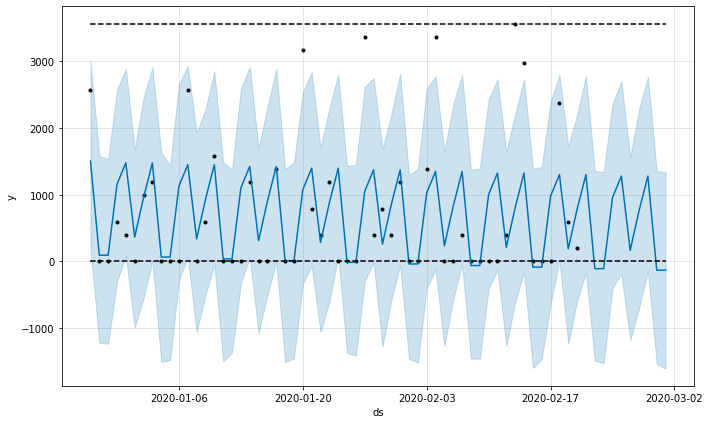

In [73]:
# Plot forecast as well as historical data 
## Black dots represent historical data
## Dark blue line is forecasting result
## Light blue region represent confidence interval 
fig=model.plot(forecast)

### 6.4. Additional Information

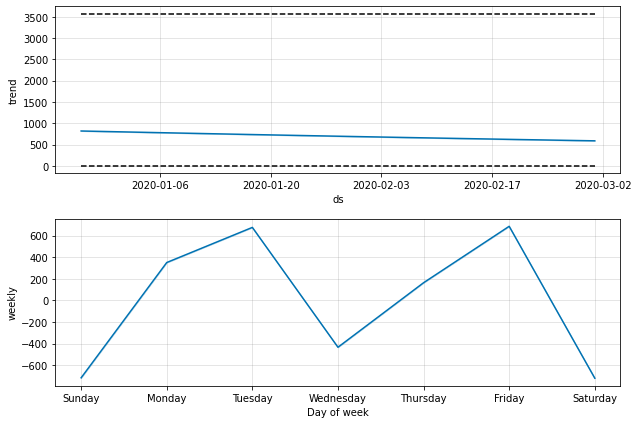

In [74]:
# Check trend and seasonality for case selected
fig2 = model.plot_components(forecast)

### 6.5. Summary

The forecasting accuracy of Fbprophet truly depends on the quality of data of specific case. If the data reveals strong trend and seasonality, Prophet would easily capture these features and generate high quality forecasting results. However, if the data shows no trend or seasonality but randomness, the forecasting error by Prophet will be increased significantly over time. For this project, the data quality varies from case to case, although the forecasting result is not perfect, but acceptable in general. 

Due to its flexibility and easiness in terms of adjusting strength of trend, seasonality, holiday effect, uncertainty, regressors and so on, Fbprophet would give user fairly good result within a short period of time. Therefore, Fbprophet can be used as a quick start of forecasting in demand but future analysis is required to achieve better result. 